- zmienione parametry czwartego czynnika (szumu)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from kdelearn.kde import KDE
from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.ckde import CKDE
from kdelearn.ckde_tasks import CKDEOutliersDetection
from kdelearn.bandwidth_selection import direct_plugin
from kdelearn.metrics import pi_kf

from matplotlib import cm

In [3]:
cmaps = (cm.Blues, cm.Oranges)
colors = ('cornflowerblue', 'goldenrod')

In [4]:
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"  # computer modern (latex default style)
matplotlib.rcParams["font.family"] = "STIXGeneral"

# Dane

Parametry mieszaniny rozkładów Gaussa używanych w dalszych przykładach:

$$
seed=1
$$

$$
m=1000
$$

$$
m_1=0.25m
$$

\begin{equation*}
E_1 =
\left(\begin{array}{c}
-3 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_1 =
\left(\begin{array}{cc}\ 
4 & -1.4\\
-1.4 & 1
\end{array}\right)
\end{equation*}


$$
m_2=0.5m
$$

\begin{equation*}
E_2 =
\left(\begin{array}{c}
2 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_2 =
\left(\begin{array}{cc}\ 
1 & 0.7\\
0.7 & 1
\end{array}\right)
\end{equation*}


$$
m_3=0.15m
$$

\begin{equation*}
E_3 =
\left(\begin{array}{c}
5 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_3 =
\left(\begin{array}{cc}\ 
1 & 0.9\\
0.9 & 1
\end{array}\right)
\end{equation*}


$$
m_4=0.1m
$$

\begin{equation*}
E_4 =
\left(\begin{array}{c}
0 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_4 =
\left(\begin{array}{cc}\ 
16 & 0\\
0 & 4
\end{array}\right)
\end{equation*}

Uwaga: Dane z 4 członu to traktowane są jako szum

## Treningowe

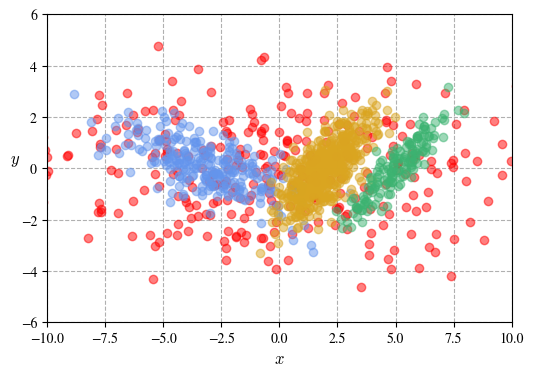

In [5]:
np.random.seed(1)

# Data
n_experiments = 100
m_train = 1000
n_x, n_y = 1, 1

# Class 1
m_train1 = int(0.25 * m_train)
mean1 = [-3, 0]
cov1 = [[4, -1.4],
        [-1.4, 1]]
# Class 2
m_train2 = int(0.5 * m_train)
mean2 = [2, 0]
cov2 = [[1, 0.7],
        [0.7, 1]]
# Class 3
m_train3 = int(0.15 * m_train)
mean3 = [5, 0]
cov3 = [[1, 0.9],
        [0.9, 1]]
# Class 4
m_train4 = int(0.3 * m_train)
mean4 = [0, 0]
cov4 = [[25, 0],
        [0, 4]]

m_train = 1200

z_train = np.empty((n_experiments, m_train, n_x + n_y))
labels_train1 = np.full(m_train1, 1, dtype=np.int32)
labels_train2 = np.full(m_train2, 2, dtype=np.int32)
labels_train3 = np.full(m_train3, 3, dtype=np.int32)
labels_train4 = np.full(m_train4, 4, dtype=np.int32)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3, labels_train4))

for e in range(n_experiments):
    # Class 1
    z_train1 = np.random.multivariate_normal(mean1, cov1, m_train1)
    # Class 2
    z_train2 = np.random.multivariate_normal(mean2, cov2, m_train2)
    # Class 3
    z_train3 = np.random.multivariate_normal(mean3, cov3, m_train3)
    # Class 4
    z_train4 = np.random.multivariate_normal(mean4, cov4, m_train4)

    z_train[e, :, :] = np.concatenate((z_train1, z_train2, z_train3, z_train4), axis=0)

x_train = z_train[:, :, [0]]
y_train = z_train[:, :, [1]]


# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train[0, -m_train4:], y_train[0, -m_train4:], c="red", zorder=2, alpha=0.5)
plt.scatter(x_train[0, :m_train1], y_train[0, :m_train1], c="cornflowerblue", zorder=2, alpha=0.5)
plt.scatter(x_train[0, m_train1:m_train1+m_train2], y_train[0, m_train1:m_train1+m_train2], c="goldenrod", zorder=2, alpha=0.5)
plt.scatter(x_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], y_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], c="mediumseagreen", zorder=2, alpha=0.5)

plt.xlim(-10, 10)
plt.ylim(-6, 6)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.grid(linestyle="--")
# plt.savefig("synthetic_data.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [6]:
bandwidth_z = np.zeros((n_experiments, n_x + n_y))
for e in range(n_experiments):
    bandwidth_z[e] = direct_plugin(z_train[e])
bandwidth_x = bandwidth_z[:, :n_x]
bandwidth_y = bandwidth_z[:, n_x:]

x_grid = np.linspace(-10, 10, 1000)[:, None]

\newpage

# Ujęcie bezwarunkowe

Do detekcji elementów nietypowych stosowana jest metoda podstawień rzędu 2.

## Pojedynczy eksperyment (r=0.05)

Wskaźnik jakości (PI_kf): 0.339514


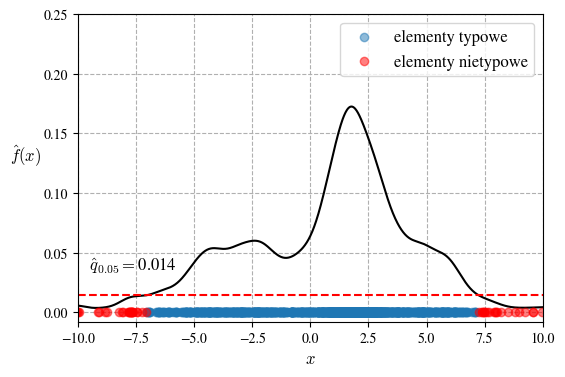

In [7]:
kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0], r=0.05)
scores = kde_outlier_detector.kde.pdf(x_grid)
labels_pred = kde_outlier_detector.predict(x_train[0])

metric = pi_kf(x_train[0], labels_pred)
print(f"Wskaźnik jakości (PI_kf): {metric:.6f}")


# true_dist1 = m_train1 / m_train * norm.pdf(x_grid, loc=-3, scale=2)
# true_dist2 = m_train2 / m_train * norm.pdf(x_grid, loc=2, scale=1)
# true_dist3 = m_train3 / m_train * norm.pdf(x_grid, loc=5, scale=1)
# true_dist4 = m_train4 / m_train * norm.pdf(x_grid, loc=0, scale=4)
# true_dist = true_dist1 + true_dist2 + true_dist3 + true_dist4


# Plot
plt.figure(figsize=(6, 4), dpi=100)

# plt.plot(x_grid, true_dist, c="grey", label="$f(x)$")
plt.plot(x_grid, scores, c="k")
plt.hlines(kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
plt.scatter(x_train[0, labels_pred==0], x_train[0, labels_pred==0]*0, alpha=0.5, zorder=2, label="elementy typowe")
plt.scatter(x_train[0, labels_pred==1], x_train[0, labels_pred==1]*0, c="red", alpha=0.5, zorder=2, label="elementy nietypowe")
plt.text(-9.5, 0.035, "$\hat{q}_{0.05} = $" + f"{kde_outlier_detector.threshold:.3f}", fontsize=12)

plt.legend(fontsize=12)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
plt.xlim(-10, 10)
plt.ylim(top=0.25)
plt.grid(linestyle="--")

# plt.savefig("synthetic_data_outliers_kde.pdf", format="pdf", bbox_inches="tight")
plt.show()

\newpage

### Dopasowanie $h$ oraz $r$ na siatce

In [8]:
h_mul_grid = (1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0)
r_grid = (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
          0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2)

print(f"Siatka dla mnożników h: {sorted(h_mul_grid)}")
print(f"Siatka dla r: {r_grid}")

Siatka dla mnożników h: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
Siatka dla r: (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2)


In [9]:
best_metric = np.inf
for h_mul in h_mul_grid:
    for r in r_grid:
        kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0] * h_mul, r=r)
        labels_pred = kde_outlier_detector.predict(x_train[0])
        metric = pi_kf(x_train[0], labels_pred, bandwidth=bandwidth_x[0] * h_mul)
        if metric < best_metric:
            best_h_mul = h_mul
            best_r = r
            best_metric = metric

print(f"Najlepszy mnożnik h: {best_h_mul:.2f} oraz r {best_r:.2f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")

Najlepszy mnożnik h: 1.00 oraz r 0.07
Przy wskaźniku jakości: 0.298058


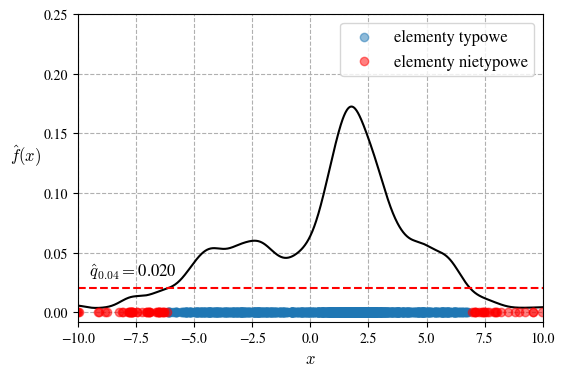

In [10]:
kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0] * best_h_mul, r=best_r)
scores = kde_outlier_detector.kde.pdf(x_grid)
labels_pred = kde_outlier_detector.predict(x_train[0])


# Plot
plt.figure(figsize=(6, 4), dpi=100)

# plt.plot(x_grid, true_dist, c="grey", label="$f(x)$")
plt.plot(x_grid, scores, c="k")
plt.hlines(kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
plt.scatter(x_train[0, labels_pred==0], x_train[0, labels_pred==0]*0, alpha=0.5, zorder=2, label="elementy typowe")
plt.scatter(x_train[0, labels_pred==1], x_train[0, labels_pred==1]*0, c="red", alpha=0.5, zorder=2, label="elementy nietypowe")
plt.text(-9.5, 0.03, "$\hat{q}_{0.04} = $" + f"{kde_outlier_detector.threshold:.3f}", fontsize=12)

plt.legend(fontsize=12)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
plt.xlim(-10, 10)
plt.ylim(top=0.25)
plt.grid(linestyle="--")
# plt.savefig("synthetic_data_outliers_kde2.pdf", format="pdf", bbox_inches="tight")
plt.show()

\newpage

## Wielokrotne eksperymenty (r=0.05)

In [11]:
metrics = np.empty((n_experiments,))
for e in range(n_experiments):
    kde_outlier_detector = KDEOutliersDetection().fit(x_train[e], bandwidth=bandwidth_x[e], r=0.05)
    labels_pred = kde_outlier_detector.predict(x_train[e])
    metrics[e] = pi_kf(x_train[e], labels_pred)

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów (pi_kf): {np.mean(metrics):.6f} +- {np.std(metrics):.6f}")

Wskaźnik jakości dla 100 eksperymentów (pi_kf): 0.298030 +- 0.040389


### Dopasowanie $h$ oraz $r$ na siatce

In [12]:
h_mul_grid = (1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0)
r_grid = (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
          0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2)

print(f"Siatka dla mnożników h: {sorted(h_mul_grid)}")
print(f"Siatka dla r: {r_grid}")

Siatka dla mnożników h: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
Siatka dla r: (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2)


In [13]:
best_metrics = np.empty((n_experiments,))
best_h_muls = np.empty((n_experiments,))
best_rs = np.empty((n_experiments,))
for e in range(n_experiments):
    
    best_metric = np.inf
    for h_mul in h_mul_grid:
        for r in r_grid:
            kde_outlier_detector = KDEOutliersDetection().fit(x_train[e], bandwidth=bandwidth_x[e] * h_mul, r=r)
            labels_pred = kde_outlier_detector.predict(x_train[e])
            metric = pi_kf(x_train[e], labels_pred, bandwidth=bandwidth_x[e] * h_mul)
            if metric < best_metric:
                best_metric = metric
                best_h_mul = h_mul
                best_r = r
    best_metrics[e] = best_metric
    best_h_muls[e] = best_h_mul
    best_rs[e] = best_r

    
print(f"Wskaźnik jakości dla {n_experiments} eksperymentów (pi_kf): {np.mean(best_metrics):.6f} +- {np.std(best_metrics):.6f}")
print(f"Średni najlepszy mnożnik h: {np.mean(best_h_muls):.6f} +- {np.std(best_h_muls):.6f}")
print(f"Średnie najlepsze r: {np.mean(best_rs):.6f} +- {np.std(best_rs):.6f}")

Wskaźnik jakości dla 100 eksperymentów (pi_kf): 0.259696 +- 0.030286
Średni najlepszy mnożnik h: 1.375000 +- 0.504455
Średnie najlepsze r: 0.035600 +- 0.016572


\newpage

# Ujęcie warunkowe

## Pojedynczy eksperyment (r=0.05, $y^* = y_i$)

In [14]:
labels_pred = np.empty(m_train, dtype=np.int32)
scores = np.empty(m_train)

for i in range(m_train):
    ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_train[0, i],
                                                        bandwidth_x=bandwidth_x[0],
                                                        bandwidth_y=bandwidth_y[0],
                                                        r=0.05)
    labels_pred[i] = ckde_outlier_detector.predict(x_train[0, [i]])
    
    scores[i] = ckde_outlier_detector.ckde.pdf(x_train[0, [i]])

In [15]:
inliers = labels_pred == 0
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()

scores_out = scores[outliers]
scores_in = np.sort(scores[inliers])[:n_outliers]

metric = np.sum(scores_out) / np.sum(scores_in)
print(f"Wskaźnik jakości (PI_kf): {metric:.6f}")

Wskaźnik jakości (PI_kf): 0.362690


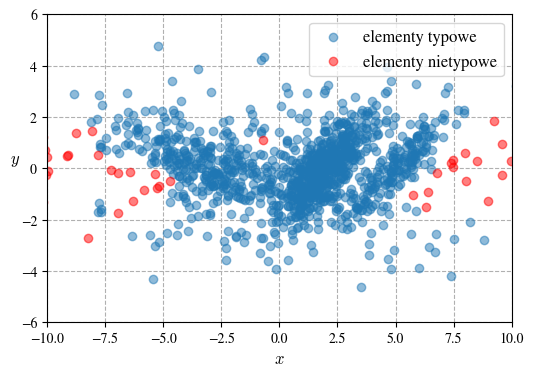

In [16]:
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train[0, labels_pred==0], y_train[0, labels_pred==0], zorder=2, alpha=0.5, label="elementy typowe")
plt.scatter(x_train[0, labels_pred==1], y_train[0, labels_pred==1], zorder=2, alpha=0.5, c="red", label="elementy nietypowe")

plt.legend(fontsize=12)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.xlim(-10, 10)
plt.ylim(-6, 6)
plt.grid(linestyle="--")
# plt.savefig("synthetic_data_outliers_ckde.pdf", format="pdf", bbox_inches="tight")
plt.show()

\newpage

### Dopasowanie $h$ oraz $r$ na siatce

In [17]:
# h_mul_grid = (1.0, 0.75, 1.25, 0.5, 1.5)
h_mul_grid = (1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0)
r_grid = (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
          0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2)

# h_mul_grid = (1.0, 0.9, 1.1, 0.8, 1.2, 0.7, 1.3, 0.6, 1.4, 0.5, 1.5)
# r_grid = (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
#           0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2)

print(f"Siatka dla mnożników h: {sorted(h_mul_grid)}")
print(f"Siatka dla r: {r_grid}")

Siatka dla mnożników h: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
Siatka dla r: (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2)


In [18]:
best_metric = np.inf
for h_mul_x in h_mul_grid:
    for h_mul_y in h_mul_grid:
        for r in r_grid:

            labels_pred = np.empty(m_train, dtype=np.int32)
            scores = np.empty(m_train)

            for i in range(m_train):
                ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_train[0, i],
                                                                    bandwidth_x=bandwidth_x[0] * h_mul_x,
                                                                    bandwidth_y=bandwidth_y[0] * h_mul_y,
                                                                    r=r)
                labels_pred[i] = ckde_outlier_detector.predict(x_train[0, [i]])

                scores[i] = ckde_outlier_detector.ckde.pdf(x_train[0, [i]])
            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()
            scores_out = scores[outliers]
            scores_in = np.sort(scores[inliers])[:n_outliers]
            metric = np.sum(scores_out) / np.sum(scores_in)

            if metric < best_metric:
                best_h_mul_x = h_mul_x
                best_h_mul_y = h_mul_y
                best_r = r
                best_metric = metric

print(f"Najlepszy mnożnik h_x: {best_h_mul_x:.2f}, h_y: {best_h_mul_y:.2f}")
print(f"Najlepsze r: {best_r:.2f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")

/tmp/ipykernel_8909/3910230964.py:22: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum(scores_out) / np.sum(scores_in)


Najlepszy mnożnik h_x: 1.00, h_y: 1.80
Najlepsze r: 0.04
Przy wskaźniku jakości: 0.310220


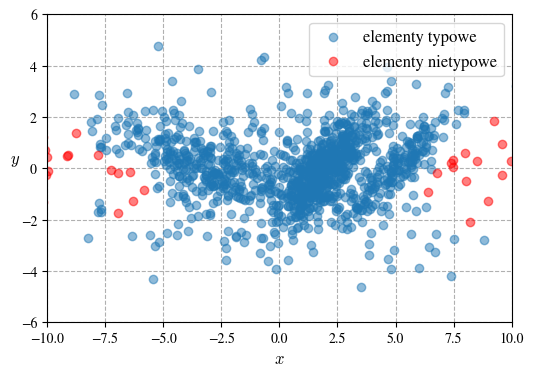

In [19]:
labels_pred = np.empty(m_train, dtype=np.int32)

for i in range(m_train):
    ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_train[0, i],
                                                        bandwidth_x=bandwidth_x[0] * best_h_mul_x,
                                                        bandwidth_y=bandwidth_y[0] * best_h_mul_y,
                                                        r=best_r)
    labels_pred[i] = ckde_outlier_detector.predict(x_train[0, [i]])
    

##
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train[0, labels_pred==0], y_train[0, labels_pred==0], zorder=2, alpha=0.5, label="elementy typowe")
plt.scatter(x_train[0, labels_pred==1], y_train[0, labels_pred==1], zorder=2, alpha=0.5, c="red", label="elementy nietypowe")

plt.legend(fontsize=12)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.xlim(-10, 10)
plt.ylim(-6, 6)
plt.grid(linestyle="--")
# plt.savefig("synthetic_data_outliers_ckde2.pdf", format="pdf", bbox_inches="tight")
plt.show()

\newpage

## Wielokrotne eksperymenty (r=0.05)

In [20]:
pis = np.empty((n_experiments,))
for e in range(n_experiments):
    labels_pred = np.empty(m_train, dtype=np.int32)
    scores = np.empty(m_train)
    for i in range(m_train):
        ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[e], y_train[e], y_train[e, i],
                                                            bandwidth_x=bandwidth_x[e],
                                                            bandwidth_y=bandwidth_y[e],
                                                            r=0.05)
        labels_pred[i] = ckde_outlier_detector.predict(x_train[e, [i]])

        scores[i] = ckde_outlier_detector.ckde.pdf(x_train[e, [i]])
        
    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    scores_out = scores[outliers]
    scores_in = np.sort(scores[inliers])[:n_outliers]
    pis[e] = np.sum(scores_out) / np.sum(scores_in)

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów: {np.mean(pis):.6f} +- {np.std(pis):.6f}")

Wskaźnik jakości dla 100 eksperymentów: 0.451552 +- 0.055849


### Dopasowanie $h$ oraz $r$ na siatce

In [21]:
# Dla siatki

h_mul_grid = (1.0, 0.75, 1.5, 0.5, 2.0)
r_grid = (0.01, 0.05, 0.1, 0.15, 0.2)

In [22]:
best_pis = np.empty((n_experiments,))
best_h_mul_xs = np.empty((n_experiments,))
best_h_mul_ys = np.empty((n_experiments,))
best_rs = np.empty((n_experiments,))

for e in range(n_experiments):
    
    best_metric = np.inf
    for h_mul_x in h_mul_grid:
        for h_mul_y in h_mul_grid:
            for r in r_grid:

                labels_pred = np.empty(m_train, dtype=np.int32)
                scores = np.empty(m_train)

                for i in range(m_train):
                    ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[e], y_train[e], y_train[e, i],
                                                                        bandwidth_x=bandwidth_x[e] * h_mul_x,
                                                                        bandwidth_y=bandwidth_y[e] * h_mul_y,
                                                                        r=r)
                    labels_pred[i] = ckde_outlier_detector.predict(x_train[e, [i]])

                    scores[i] = ckde_outlier_detector.ckde.pdf(x_train[e, [i]])
                inliers = labels_pred == 0
                outliers = labels_pred == 1
                n_outliers = (outliers == 1).sum()
                scores_out = scores[outliers]
                scores_in = np.sort(scores[inliers])[:n_outliers]
                metric = np.sum(scores_out) / np.sum(scores_in)

                if metric < best_metric:
                    best_h_mul_x = h_mul_x
                    best_h_mul_y = h_mul_y
                    best_r = r
                    best_metric = metric
    best_pis[e] = best_metric
    best_h_mul_xs[e] = best_h_mul_x
    best_h_mul_ys[e] = best_h_mul_y
    best_rs[e] = best_r

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów: {np.mean(best_pis):.6f} +- {np.std(best_pis):.6f}")
print(f"Średni najlepszy mnożnik h_x: {np.mean(best_h_mul_xs):.6f} +- {np.std(best_h_mul_xs):.6f}")
print(f"Średni najlepszy mnożnik h_y: {np.mean(best_h_mul_ys):.6f} +- {np.std(best_h_mul_ys):.6f}")
print(f"Średnie najlepsze r: {np.mean(best_rs):.6f} +- {np.std(best_rs):.6f}")

/tmp/ipykernel_8909/3061556696.py:29: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum(scores_out) / np.sum(scores_in)


Wskaźnik jakości dla 100 eksperymentów: 0.361806 +- 0.037021
Średni najlepszy mnożnik h_x: 1.387500 +- 0.461485
Średni najlepszy mnożnik h_y: 1.922500 +- 0.217069
Średnie najlepsze r: 0.048300 +- 0.014146


## Testowanie przy ustalonym $y^*$

### $y^*=-2$

In [1]:
y_star = np.array([-2.0] * n_y)


ckde_outlier_detector_neg1 = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                         bandwidth_x=bandwidth_x[0],
                                                         bandwidth_y=bandwidth_y[0],
                                                         r=0.01)
scores_neg1 = ckde_outlier_detector_neg1.ckde.pdf(x_grid)
labels_pred1 = ckde_outlier_detector_neg1.predict(x_train[0])

ckde_outlier_detector_neg2 = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                         bandwidth_x=bandwidth_x[0],
                                                         bandwidth_y=bandwidth_y[0],
                                                         r=0.05)
scores_neg2 = ckde_outlier_detector_neg2.ckde.pdf(x_grid)
labels_pred2 = ckde_outlier_detector_neg2.predict(x_train[0])

ckde_outlier_detector_neg3 = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                         bandwidth_x=bandwidth_x[0],
                                                         bandwidth_y=bandwidth_y[0],
                                                         r=0.1)
scores_neg3 = ckde_outlier_detector_neg3.ckde.pdf(x_grid)
labels_pred3 = ckde_outlier_detector_neg3.predict(x_train[0])



fig, axs = plt.subplots(2, 3, figsize=(12, 6), dpi=100)

axs[0, 0].plot(x_grid, scores_neg1, c="k")
axs[0, 0].hlines(ckde_outlier_detector_neg1.threshold, -10, 10, linestyle="--", color="r")
axs[0, 0].text(-9.5, 0.07, "$\hat{q}_{0.01} = $" + f"{ckde_outlier_detector_neg1.threshold:.3f}", fontsize=12)
axs[0, 0].set_xlabel("$x$", fontsize=12)
axs[0, 0].set_ylabel("$\hat{f}(x)$", rotation=0, fontsize=12, labelpad=16)
axs[0, 0].set_xlim(-10, 10)
axs[0, 0].set_ylim(top=0.4)
axs[0, 0].grid(linestyle="--")

axs[0, 1].plot(x_grid, scores_neg2, c="k")
axs[0, 1].hlines(ckde_outlier_detector_neg2.threshold, -10, 10, linestyle="--", color="r")
axs[0, 1].text(-9.5, 0.07, "$\hat{q}_{0.05} = $" + f"{ckde_outlier_detector_neg2.threshold:.3f}", fontsize=12)
axs[0, 1].set_xlabel("$x$", fontsize=12)
axs[0, 1].set_xlim(-10, 10)
axs[0, 1].set_ylim(top=0.4)
axs[0, 1].grid(linestyle="--")

axs[0, 2].plot(x_grid, scores_neg3, c="k")
axs[0, 2].hlines(ckde_outlier_detector_neg3.threshold, -10, 10, linestyle="--", color="r")
axs[0, 2].text(-9.5, 0.07, "$\hat{q}_{0.1} = $" + f"{ckde_outlier_detector_neg3.threshold:.3f}", fontsize=12)
axs[0, 2].set_xlabel("$x$", fontsize=12)
axs[0, 2].set_xlim(-10, 10)
axs[0, 2].set_ylim(top=0.4)
axs[0, 2].grid(linestyle="--")


axs[1, 0].scatter(x_train[0, labels_pred1==0], y_train[0, labels_pred1==0], zorder=2, alpha=0.1, c="#1f77b4")
cond0 = ((labels_pred1==0) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 0].scatter(x_train[0, cond0], y_train[0, cond0], zorder=2, alpha=0.8, c="#1f77b4")
axs[1, 0].scatter(x_train[0, labels_pred1==1], y_train[0, labels_pred1==1], zorder=2, alpha=0.1, c="red")
cond1 = ((labels_pred1==1) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 0].scatter(x_train[0, cond1], y_train[0, cond1], zorder=2, alpha=0.8, c="red")
axs[1, 0].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1, 0].set_xlabel("$x$", fontsize=12)
axs[1, 0].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1, 0].set_xlim(-10, 10)
axs[1, 0].set_ylim(-6, 6)
axs[1, 0].grid(linestyle="--")

axs[1, 1].scatter(x_train[0, labels_pred2==0], y_train[0, labels_pred2==0], zorder=2, alpha=0.1, c="#1f77b4")
cond0 = ((labels_pred2==0) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 1].scatter(x_train[0, cond0], y_train[0, cond0], zorder=2, alpha=0.8, c="#1f77b4")
axs[1, 1].scatter(x_train[0, labels_pred2==1], y_train[0, labels_pred2==1], zorder=2, alpha=0.1, c="red")
cond1 = ((labels_pred2==1) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 1].scatter(x_train[0, cond1], y_train[0, cond1], zorder=2, alpha=0.8, c="red")
axs[1, 1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1, 1].set_xlabel("$x$", fontsize=12)
axs[1, 1].set_xlim(-10, 10)
axs[1, 1].set_ylim(-6, 6)
axs[1, 1].grid(linestyle="--")

axs[1, 2].scatter(x_train[0, labels_pred3==0], y_train[0, labels_pred3==0], zorder=2, alpha=0.1, c="#1f77b4")
cond0 = ((labels_pred3==0) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 2].scatter(x_train[0, cond0], y_train[0, cond0], zorder=2, alpha=0.8, c="#1f77b4")
axs[1, 2].scatter(x_train[0, labels_pred3==1], y_train[0, labels_pred3==1], zorder=2, alpha=0.1, c="red")
cond1 = ((labels_pred3==1) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 2].scatter(x_train[0, cond1], y_train[0, cond1], zorder=2, alpha=0.8, c="red")
axs[1, 2].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1, 2].set_xlabel("$x$", fontsize=12)
axs[1, 2].set_xlim(-10, 10)
axs[1, 2].set_ylim(-6, 6)
axs[1, 2].grid(linestyle="--")

plt.tight_layout()
# plt.savefig("synthetic_data_outliers_ckde_extra1.pdf", format="pdf", bbox_inches="tight")

plt.show()

NameError: name 'np' is not defined

\newpage

### $y^*=0$

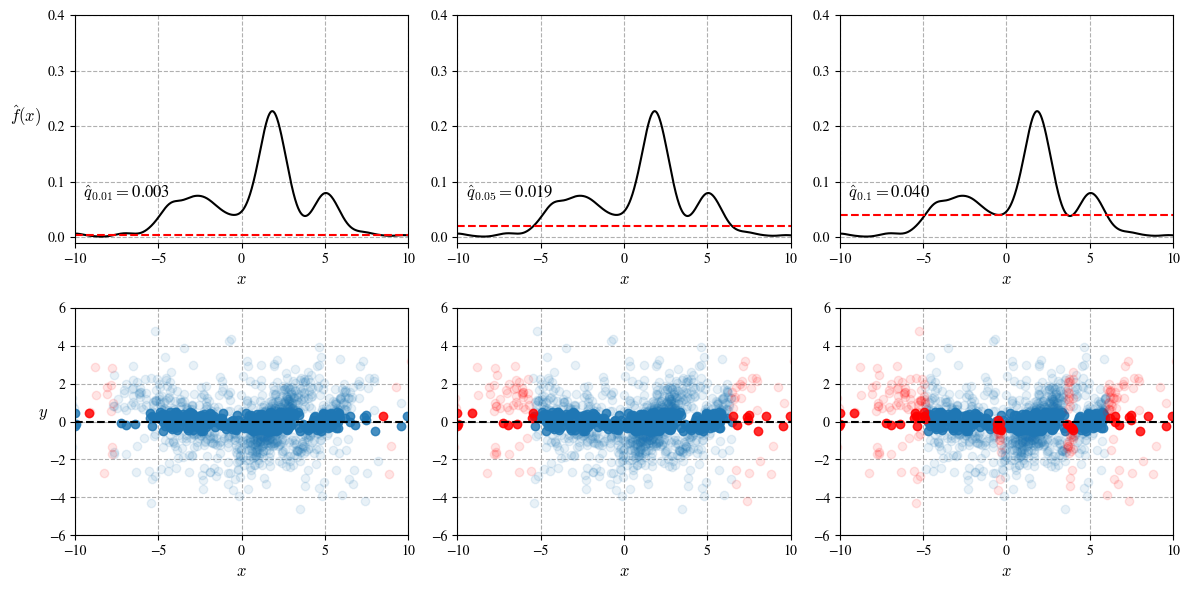

In [24]:
y_star = np.array([0.0] * n_y)


ckde_outlier_detector_neg1 = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                         bandwidth_x=bandwidth_x[0],
                                                         bandwidth_y=bandwidth_y[0],
                                                         r=0.01)
scores_neg1 = ckde_outlier_detector_neg1.ckde.pdf(x_grid)
labels_pred1 = ckde_outlier_detector_neg1.predict(x_train[0])

ckde_outlier_detector_neg2 = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                         bandwidth_x=bandwidth_x[0],
                                                         bandwidth_y=bandwidth_y[0],
                                                         r=0.05)
scores_neg2 = ckde_outlier_detector_neg2.ckde.pdf(x_grid)
labels_pred2 = ckde_outlier_detector_neg2.predict(x_train[0])

ckde_outlier_detector_neg3 = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                         bandwidth_x=bandwidth_x[0],
                                                         bandwidth_y=bandwidth_y[0],
                                                         r=0.1)
scores_neg3 = ckde_outlier_detector_neg3.ckde.pdf(x_grid)
labels_pred3 = ckde_outlier_detector_neg3.predict(x_train[0])



fig, axs = plt.subplots(2, 3, figsize=(12, 6), dpi=100)

axs[0, 0].plot(x_grid, scores_neg1, c="k")
axs[0, 0].hlines(ckde_outlier_detector_neg1.threshold, -10, 10, linestyle="--", color="r")
axs[0, 0].text(-9.5, 0.07, "$\hat{q}_{0.01} = $" + f"{ckde_outlier_detector_neg1.threshold:.3f}", fontsize=12)
axs[0, 0].set_xlabel("$x$", fontsize=12)
axs[0, 0].set_ylabel("$\hat{f}(x)$", rotation=0, fontsize=12, labelpad=16)
axs[0, 0].set_xlim(-10, 10)
axs[0, 0].set_ylim(top=0.4)
axs[0, 0].grid(linestyle="--")

axs[0, 1].plot(x_grid, scores_neg2, c="k")
axs[0, 1].hlines(ckde_outlier_detector_neg2.threshold, -10, 10, linestyle="--", color="r")
axs[0, 1].text(-9.5, 0.07, "$\hat{q}_{0.05} = $" + f"{ckde_outlier_detector_neg2.threshold:.3f}", fontsize=12)
axs[0, 1].set_xlabel("$x$", fontsize=12)
axs[0, 1].set_xlim(-10, 10)
axs[0, 1].set_ylim(top=0.4)
axs[0, 1].grid(linestyle="--")

axs[0, 2].plot(x_grid, scores_neg3, c="k")
axs[0, 2].hlines(ckde_outlier_detector_neg3.threshold, -10, 10, linestyle="--", color="r")
axs[0, 2].text(-9.5, 0.07, "$\hat{q}_{0.1} = $" + f"{ckde_outlier_detector_neg3.threshold:.3f}", fontsize=12)
axs[0, 2].set_xlabel("$x$", fontsize=12)
axs[0, 2].set_xlim(-10, 10)
axs[0, 2].set_ylim(top=0.4)
axs[0, 2].grid(linestyle="--")


axs[1, 0].scatter(x_train[0, labels_pred1==0], y_train[0, labels_pred1==0], zorder=2, alpha=0.1, c="#1f77b4")
cond0 = ((labels_pred1==0) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 0].scatter(x_train[0, cond0], y_train[0, cond0], zorder=2, alpha=0.8, c="#1f77b4")
axs[1, 0].scatter(x_train[0, labels_pred1==1], y_train[0, labels_pred1==1], zorder=2, alpha=0.1, c="red")
cond1 = ((labels_pred1==1) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 0].scatter(x_train[0, cond1], y_train[0, cond1], zorder=2, alpha=0.8, c="red")
axs[1, 0].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1, 0].set_xlabel("$x$", fontsize=12)
axs[1, 0].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1, 0].set_xlim(-10, 10)
axs[1, 0].set_ylim(-6, 6)
axs[1, 0].grid(linestyle="--")

axs[1, 1].scatter(x_train[0, labels_pred2==0], y_train[0, labels_pred2==0], zorder=2, alpha=0.1, c="#1f77b4")
cond0 = ((labels_pred2==0) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 1].scatter(x_train[0, cond0], y_train[0, cond0], zorder=2, alpha=0.8, c="#1f77b4")
axs[1, 1].scatter(x_train[0, labels_pred2==1], y_train[0, labels_pred2==1], zorder=2, alpha=0.1, c="red")
cond1 = ((labels_pred2==1) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 1].scatter(x_train[0, cond1], y_train[0, cond1], zorder=2, alpha=0.8, c="red")
axs[1, 1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1, 1].set_xlabel("$x$", fontsize=12)
axs[1, 1].set_xlim(-10, 10)
axs[1, 1].set_ylim(-6, 6)
axs[1, 1].grid(linestyle="--")

axs[1, 2].scatter(x_train[0, labels_pred3==0], y_train[0, labels_pred3==0], zorder=2, alpha=0.1, c="#1f77b4")
cond0 = ((labels_pred3==0) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 2].scatter(x_train[0, cond0], y_train[0, cond0], zorder=2, alpha=0.8, c="#1f77b4")
axs[1, 2].scatter(x_train[0, labels_pred3==1], y_train[0, labels_pred3==1], zorder=2, alpha=0.1, c="red")
cond1 = ((labels_pred3==1) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 2].scatter(x_train[0, cond1], y_train[0, cond1], zorder=2, alpha=0.8, c="red")
axs[1, 2].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1, 2].set_xlabel("$x$", fontsize=12)
axs[1, 2].set_xlim(-10, 10)
axs[1, 2].set_ylim(-6, 6)
axs[1, 2].grid(linestyle="--")

plt.tight_layout()
# plt.savefig("synthetic_data_outliers_ckde_extra2.pdf", format="pdf", bbox_inches="tight")

plt.show()

\newpage

### $y^*=2$

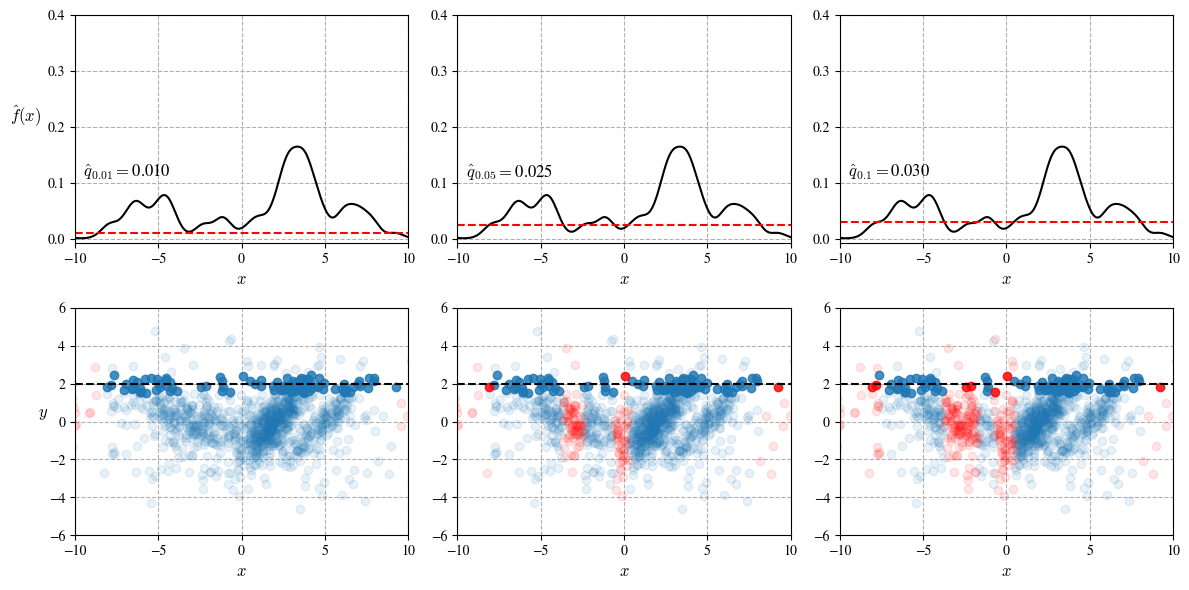

In [25]:
y_star = np.array([2.0] * n_y)


ckde_outlier_detector_neg1 = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                         bandwidth_x=bandwidth_x[0],
                                                         bandwidth_y=bandwidth_y[0],
                                                         r=0.01)
scores_neg1 = ckde_outlier_detector_neg1.ckde.pdf(x_grid)
labels_pred1 = ckde_outlier_detector_neg1.predict(x_train[0])

ckde_outlier_detector_neg2 = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                         bandwidth_x=bandwidth_x[0],
                                                         bandwidth_y=bandwidth_y[0],
                                                         r=0.05)
scores_neg2 = ckde_outlier_detector_neg2.ckde.pdf(x_grid)
labels_pred2 = ckde_outlier_detector_neg2.predict(x_train[0])

ckde_outlier_detector_neg3 = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                         bandwidth_x=bandwidth_x[0],
                                                         bandwidth_y=bandwidth_y[0],
                                                         r=0.1)
scores_neg3 = ckde_outlier_detector_neg3.ckde.pdf(x_grid)
labels_pred3 = ckde_outlier_detector_neg3.predict(x_train[0])



fig, axs = plt.subplots(2, 3, figsize=(12, 6), dpi=100)

axs[0, 0].plot(x_grid, scores_neg1, c="k")
axs[0, 0].hlines(ckde_outlier_detector_neg1.threshold, -10, 10, linestyle="--", color="r")
axs[0, 0].text(-9.5, 0.11, "$\hat{q}_{0.01} = $" + f"{ckde_outlier_detector_neg1.threshold:.3f}", fontsize=12)
axs[0, 0].set_xlabel("$x$", fontsize=12)
axs[0, 0].set_ylabel("$\hat{f}(x)$", rotation=0, fontsize=12, labelpad=16)
axs[0, 0].set_xlim(-10, 10)
axs[0, 0].set_ylim(top=0.4)
axs[0, 0].grid(linestyle="--")

axs[0, 1].plot(x_grid, scores_neg2, c="k")
axs[0, 1].hlines(ckde_outlier_detector_neg2.threshold, -10, 10, linestyle="--", color="r")
axs[0, 1].text(-9.5, 0.11, "$\hat{q}_{0.05} = $" + f"{ckde_outlier_detector_neg2.threshold:.3f}", fontsize=12)
axs[0, 1].set_xlabel("$x$", fontsize=12)
axs[0, 1].set_xlim(-10, 10)
axs[0, 1].set_ylim(top=0.4)
axs[0, 1].grid(linestyle="--")

axs[0, 2].plot(x_grid, scores_neg3, c="k")
axs[0, 2].hlines(ckde_outlier_detector_neg3.threshold, -10, 10, linestyle="--", color="r")
axs[0, 2].text(-9.5, 0.11, "$\hat{q}_{0.1} = $" + f"{ckde_outlier_detector_neg3.threshold:.3f}", fontsize=12)
axs[0, 2].set_xlabel("$x$", fontsize=12)
axs[0, 2].set_xlim(-10, 10)
axs[0, 2].set_ylim(top=0.4)
axs[0, 2].grid(linestyle="--")


axs[1, 0].scatter(x_train[0, labels_pred1==0], y_train[0, labels_pred1==0], zorder=2, alpha=0.1, c="#1f77b4")
cond0 = ((labels_pred1==0) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 0].scatter(x_train[0, cond0], y_train[0, cond0], zorder=2, alpha=0.8, c="#1f77b4")
axs[1, 0].scatter(x_train[0, labels_pred1==1], y_train[0, labels_pred1==1], zorder=2, alpha=0.1, c="red")
cond1 = ((labels_pred1==1) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 0].scatter(x_train[0, cond1], y_train[0, cond1], zorder=2, alpha=0.8, c="red")
axs[1, 0].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1, 0].set_xlabel("$x$", fontsize=12)
axs[1, 0].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1, 0].set_xlim(-10, 10)
axs[1, 0].set_ylim(-6, 6)
axs[1, 0].grid(linestyle="--")

axs[1, 1].scatter(x_train[0, labels_pred2==0], y_train[0, labels_pred2==0], zorder=2, alpha=0.1, c="#1f77b4")
cond0 = ((labels_pred2==0) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 1].scatter(x_train[0, cond0], y_train[0, cond0], zorder=2, alpha=0.8, c="#1f77b4")
axs[1, 1].scatter(x_train[0, labels_pred2==1], y_train[0, labels_pred2==1], zorder=2, alpha=0.1, c="red")
cond1 = ((labels_pred2==1) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 1].scatter(x_train[0, cond1], y_train[0, cond1], zorder=2, alpha=0.8, c="red")
axs[1, 1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1, 1].set_xlabel("$x$", fontsize=12)
axs[1, 1].set_xlim(-10, 10)
axs[1, 1].set_ylim(-6, 6)
axs[1, 1].grid(linestyle="--")

axs[1, 2].scatter(x_train[0, labels_pred3==0], y_train[0, labels_pred3==0], zorder=2, alpha=0.1, c="#1f77b4")
cond0 = ((labels_pred3==0) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 2].scatter(x_train[0, cond0], y_train[0, cond0], zorder=2, alpha=0.8, c="#1f77b4")
axs[1, 2].scatter(x_train[0, labels_pred3==1], y_train[0, labels_pred3==1], zorder=2, alpha=0.1, c="red")
cond1 = ((labels_pred3==1) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5))
axs[1, 2].scatter(x_train[0, cond1], y_train[0, cond1], zorder=2, alpha=0.8, c="red")
axs[1, 2].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1, 2].set_xlabel("$x$", fontsize=12)
axs[1, 2].set_xlim(-10, 10)
axs[1, 2].set_ylim(-6, 6)
axs[1, 2].grid(linestyle="--")

plt.tight_layout()
# plt.savefig("synthetic_data_outliers_ckde_extra3.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Rysunki

## warunkowe vs bezwarunkowe ($r=0.05$) vs warunkowe ($r=0.05$, $y^*=y_i$)

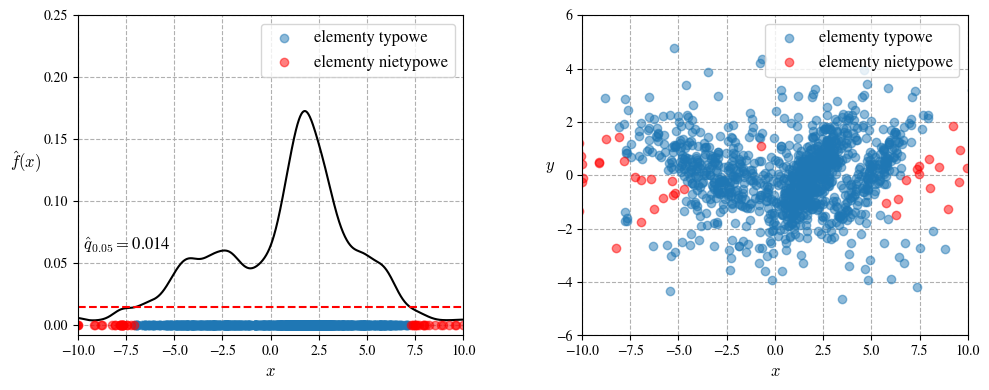

In [26]:
# bezwarunkowe
kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0], r=0.05)
scores1 = kde_outlier_detector.kde.pdf(x_grid)
labels_pred1 = kde_outlier_detector.predict(x_train[0])

# warunkowe
labels_pred2 = np.empty(m_train, dtype=np.int32)
scores2 = np.empty(m_train)
for i in range(m_train):
    ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_train[0, i],
                                                        bandwidth_x=bandwidth_x[0],
                                                        bandwidth_y=bandwidth_y[0],
                                                        r=0.05)
    labels_pred2[i] = ckde_outlier_detector.predict(x_train[0, [i]])
    
    scores2[i] = ckde_outlier_detector.ckde.pdf(x_train[0, [i]])


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores1, c="k")
axs[0].hlines(kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].scatter(x_train[0, labels_pred1==0], x_train[0, labels_pred1==0]*0, alpha=0.5, zorder=2, label="elementy typowe")
axs[0].scatter(x_train[0, labels_pred1==1], x_train[0, labels_pred1==1]*0, c="red", alpha=0.5, zorder=2, label="elementy nietypowe")
axs[0].text(-9.75, 0.06, "$\hat{q}_{0.05} = $" + f"{kde_outlier_detector.threshold:.3f}", fontsize=12)

axs[0].legend(fontsize=12)
axs[0].set_xlabel("$x$", fontsize=12)
axs[0].set_ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.25)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0, labels_pred2==0], y_train[0, labels_pred2==0], zorder=2, alpha=0.5, label="elementy typowe")
axs[1].scatter(x_train[0, labels_pred2==1], y_train[0, labels_pred2==1], zorder=2, alpha=0.5, c="red", label="elementy nietypowe")

axs[1].legend(fontsize=12)
axs[1].set_xlabel("$x$", fontsize=12)
axs[1].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout(w_pad=5)
# plt.savefig("synthetic_data_outliers_kde_and_ckde.pdf", format="pdf", bbox_inches="tight")
plt.show()

## dopasowanie parametrów

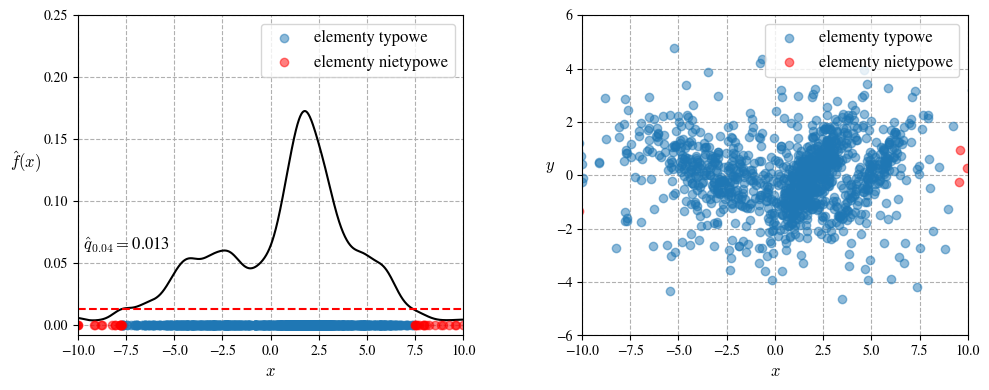

In [27]:
# bezwarunkowe
kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0] * 1.0, r=0.04)
scores1 = kde_outlier_detector.kde.pdf(x_grid)
labels_pred1 = kde_outlier_detector.predict(x_train[0])

# warunkowe
labels_pred2 = np.empty(m_train, dtype=np.int32)
scores2 = np.empty(m_train)
for i in range(m_train):
    ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_train[0, i],
                                                        bandwidth_x=bandwidth_x[0] * 1.8,
                                                        bandwidth_y=bandwidth_y[0] * 1.8,
                                                        r=0.01)
    labels_pred2[i] = ckde_outlier_detector.predict(x_train[0, [i]])
    
    scores2[i] = ckde_outlier_detector.ckde.pdf(x_train[0, [i]])


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores1, c="k")
axs[0].hlines(kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].scatter(x_train[0, labels_pred1==0], x_train[0, labels_pred1==0]*0, alpha=0.5, zorder=2, label="elementy typowe")
axs[0].scatter(x_train[0, labels_pred1==1], x_train[0, labels_pred1==1]*0, c="red", alpha=0.5, zorder=2, label="elementy nietypowe")
axs[0].text(-9.75, 0.06, "$\hat{q}_{0.04} = $" + f"{kde_outlier_detector.threshold:.3f}", fontsize=12)

axs[0].legend(fontsize=12)
axs[0].set_xlabel("$x$", fontsize=12)
axs[0].set_ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.25)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0, labels_pred2==0], y_train[0, labels_pred2==0], zorder=2, alpha=0.5, label="elementy typowe")
axs[1].scatter(x_train[0, labels_pred2==1], y_train[0, labels_pred2==1], zorder=2, alpha=0.5, c="red", label="elementy nietypowe")

axs[1].legend(fontsize=12)
axs[1].set_xlabel("$x$", fontsize=12)
axs[1].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout(w_pad=5)
# plt.savefig("synthetic_data_outliers_kde_and_ckde2.pdf", format="pdf", bbox_inches="tight")
plt.show()